# Taming Transformers
## Reconstruction Capabilities of VQGAN

This notebook provides code to (visually) analyze the first stage models used to generate images as in [Taming Transformers for High-Resolution Image Synthesis](https://github.com/CompVis/taming-transformers)
and a comparison to the first stage model used in [DALL-E](https://openai.com/blog/dall-e/).

In [3]:
#Clonet the repo and locate to it:
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1335, done.
remote: Counting objects: 100% (525/525), done.
remote: Compressing objects: 100% (493/493), done.
remote: Total 1335 (delta 58), reused 479 (delta 30), pack-reused 810
Receiving objects: 100% (1335/1335), 412.35 MiB | 49.39 MiB/s, done.
Resolving deltas: 100% (267/267), done.
/content/taming-transformers/taming-transformers


In [4]:
# download a VQGAN with f=16 (16x compression per spatial dimension) and with a codebook with 1024 entries
!mkdir -p logs/vqgan_imagenet_f16_1024/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_1024/configs
!wget 'https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt' 
!wget 'https://heibox.uni-heidelberg.de/f/6ecf2af6c658432c8298/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/configs/model.yaml' 

# download a VQGAN with f=16 (16x compression per spatial dimension) and with a larger codebook (16384 entries)
!mkdir -p logs/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_16384/configs
!wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
!wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/configs/model.yaml' 

# download a VQGAN with f=8 (8x compression per spatial dimension) and a larger codebook-size with 8192 entries
!mkdir -p logs/vqgan_gumbel_f8/checkpoints
!mkdir -p logs/vqgan_gumbel_f8/configs
!wget 'https://heibox.uni-heidelberg.de/f/34a747d5765840b5a99d/?dl=1' -O 'logs/vqgan_gumbel_f8/checkpoints/last.ckpt' 
!wget 'https://heibox.uni-heidelberg.de/f/b24d14998a8d4f19a34f/?dl=1' -O 'logs/vqgan_gumbel_f8/configs/model.yaml' 

--2022-01-22 15:05:46--  https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/fd67f4b2-13eb-4811-a671-8b0cca0289f3/last.ckpt [following]
--2022-01-22 15:05:46--  https://heibox.uni-heidelberg.de/seafhttp/files/fd67f4b2-13eb-4811-a671-8b0cca0289f3/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 957954257 (914M) [application/octet-stream]
Saving to: ‘logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt’

logs/vqgan_imagenet 100%[===================>] 913.58M  14.9MB/s    in 61s     

2022-01-22 15:06:47 (15.0 MB/s) - ‘logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt’ saved [957954257/957954257]

--2022-01-22 15:06:47--  h

In [5]:
#Install some dependencies:
%%capture
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops>=0.3.0
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
#Define some loading utilities
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

## Load the VQGANs

In [9]:
#Load the model configs. Then, load the VQGAN models.
config1024 = load_config("logs/vqgan_imagenet_f16_1024/configs/model.yaml", display=False)
config16384 = load_config("logs/vqgan_imagenet_f16_16384/configs/model.yaml", display=False)

model1024 = load_vqgan(config1024, ckpt_path="logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt").to(DEVICE)
model16384 = load_vqgan(config16384, ckpt_path="logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 577kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [10]:
#Also load a f8 model. This model trades compressive power for higher reconstruction fidelity.
config32x32 = load_config("logs/vqgan_gumbel_f8/configs/model.yaml", display=False)
model32x32 = load_vqgan(config32x32, ckpt_path="logs/vqgan_gumbel_f8/checkpoints/last.ckpt", is_gumbel=True).to(DEVICE)

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


## DALL-E


In [11]:
#Install DALL-E
%pip install git+https://github.com/openai/DALL-E.git &> /dev/null

In [15]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf", 22)

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))


def preprocess(img, target_image_size=256, map_dalle=True):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    if map_dalle: 
      img = map_pixels(img)
    return img


def reconstruct_with_dalle(x, encoder, decoder, do_preprocess=False):
  # takes in tensor (or optionally, a PIL image) and returns a PIL image
  if do_preprocess:
    x = preprocess(x)
  z_logits = encoder(x)
  z = torch.argmax(z_logits, axis=1)
  
  print(f"DALL-E: latent shape: {z.shape}")
  z = F.one_hot(z, num_classes=encoder.vocab_size).permute(0, 3, 1, 2).float()

  x_stats = decoder(z).float()
  x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
  x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

  return x_rec


def stack_reconstructions(input, x0, x1, x2, x3, titles=[]):
  assert input.size == x1.size == x2.size == x3.size
  w, h = input.size[0], input.size[1]
  img = Image.new("RGB", (5*w, h))
  img.paste(input, (0,0))
  img.paste(x0, (1*w,0))
  img.paste(x1, (2*w,0))
  img.paste(x2, (3*w,0))
  img.paste(x3, (4*w,0))
  for i, title in enumerate(titles):
    ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255), font=font) # coordinates, text, color, font
  return img

In [17]:
# Load the provided encoder and decoder.
encoder_dalle = load_model("https://cdn.openai.com/dall-e/encoder.pkl", DEVICE)
decoder_dalle = load_model("https://cdn.openai.com/dall-e/decoder.pkl", DEVICE)

## Image reconstruction


In [18]:
#Define the reconstruction pipeline and stack the reconstructions for a direct comparison.

titles=["Input", "DALL-E dVAE (f8, 8192)", "VQGAN (f8, 8192)", 
        "VQGAN (f16, 16384)", "VQGAN (f16, 1024)"]

def reconstruction_pipeline(url, size=320):
  x_dalle = preprocess(download_image(url), target_image_size=size, map_dalle=True)
  x_vqgan = preprocess(download_image(url), target_image_size=size, map_dalle=False)
  x_dalle = x_dalle.to(DEVICE)
  x_vqgan = x_vqgan.to(DEVICE)
  
  print(f"input is of size: {x_vqgan.shape}")
  x0 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model32x32)
  x1 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model16384)
  x2 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model1024)
  x3 = reconstruct_with_dalle(x_dalle, encoder_dalle, decoder_dalle)
  img = stack_reconstructions(custom_to_pil(preprocess_vqgan(x_vqgan[0])), x3, 
                              custom_to_pil(x0[0]), custom_to_pil(x1[0]), 
                              custom_to_pil(x2[0]), titles=titles)
  return img

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- GumbelVQ: latent shape: torch.Size([48, 48])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
DALL-E: latent shape: torch.Size([1, 48, 48])


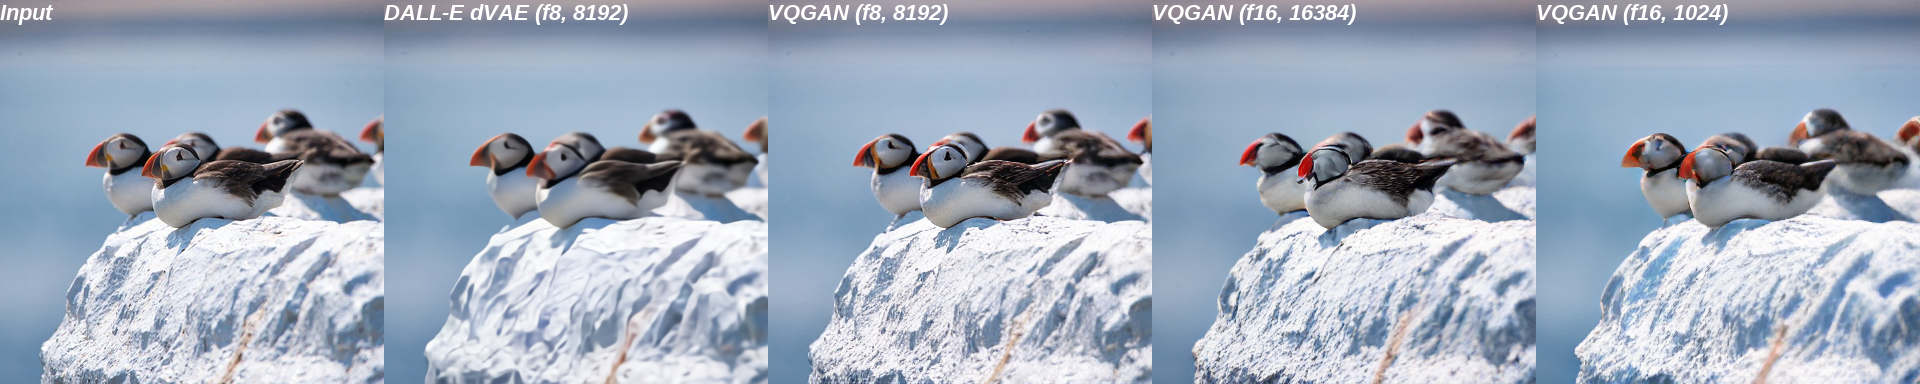

In [19]:
reconstruction_pipeline(url='https://cdn.pixabay.com/photo/2018/07/28/02/26/puffins-3567175_960_720.jpg', size=384)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- GumbelVQ: latent shape: torch.Size([48, 48])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
DALL-E: latent shape: torch.Size([1, 48, 48])


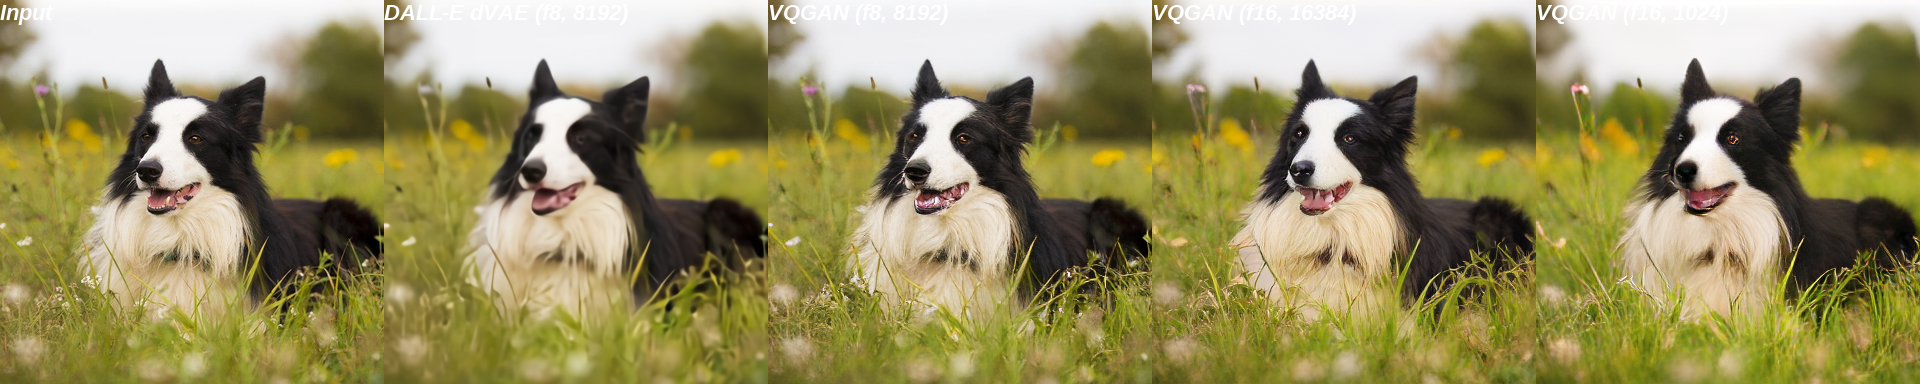

In [20]:
reconstruction_pipeline(url='https://cdn.pixabay.com/photo/2021/07/06/14/38/border-collie-6391794_960_720.jpg', size=384)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- GumbelVQ: latent shape: torch.Size([48, 48])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
DALL-E: latent shape: torch.Size([1, 48, 48])


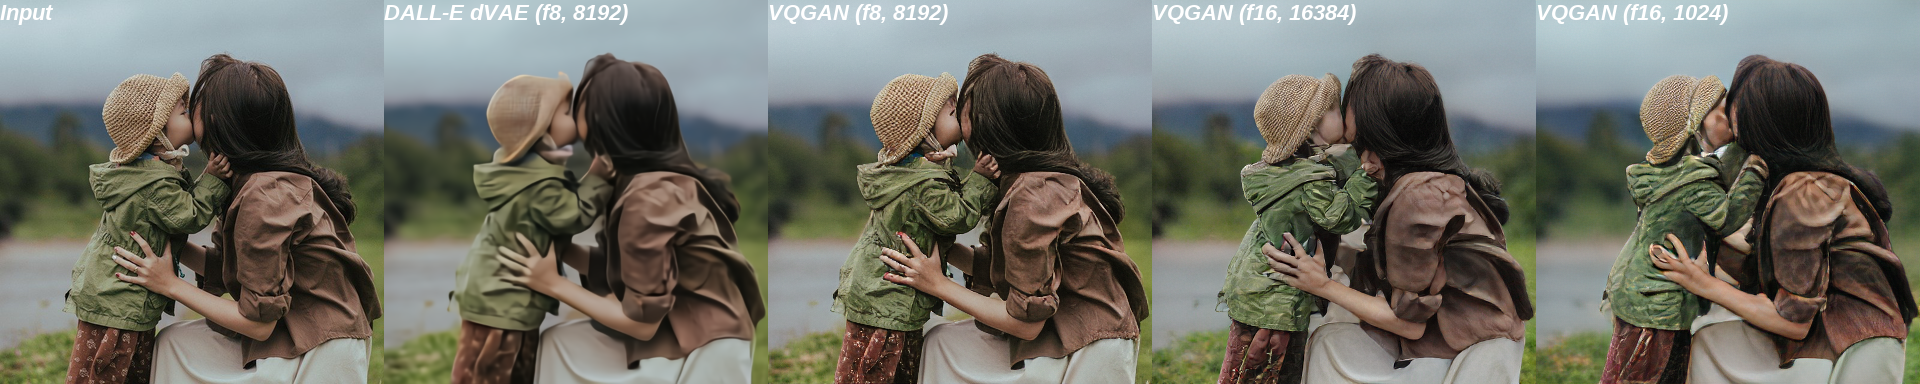

In [21]:
reconstruction_pipeline(url='https://cdn.pixabay.com/photo/2022/01/13/14/02/mother-6935336_960_720.jpg', size=384)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- GumbelVQ: latent shape: torch.Size([48, 48])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
DALL-E: latent shape: torch.Size([1, 48, 48])


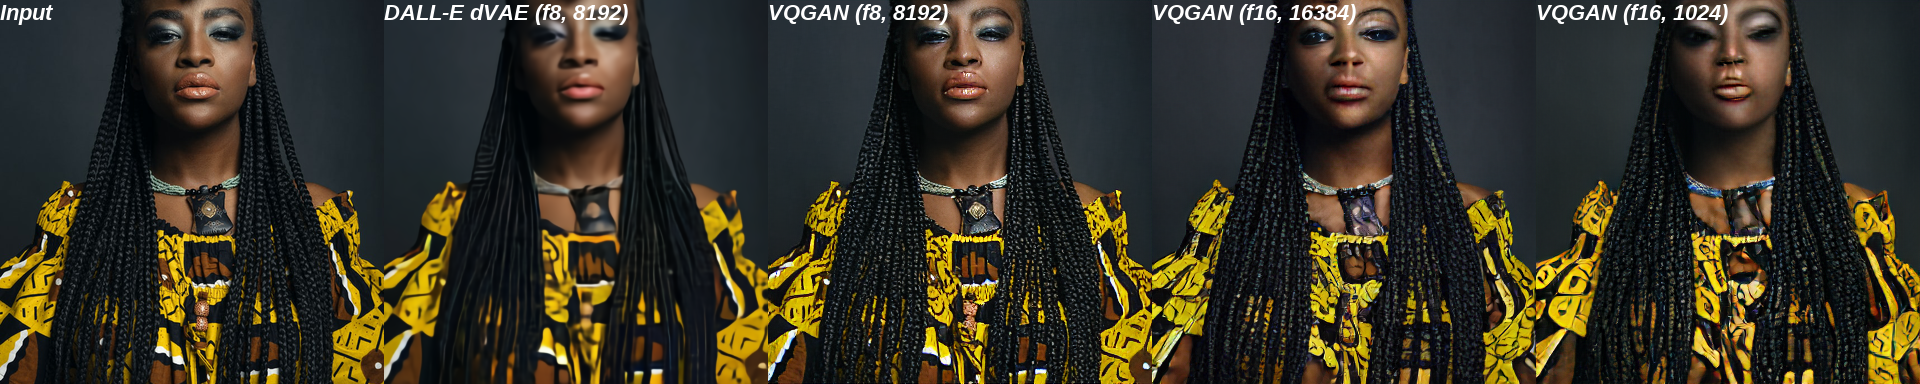

In [22]:
reconstruction_pipeline(url='https://images.unsplash.com/photo-1642757731331-fd9dfdf773e1?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=687&q=80', size=384)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


input is of size: torch.Size([1, 3, 384, 384])
VQGAN --- GumbelVQ: latent shape: torch.Size([48, 48])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
VQGAN --- VQModel: latent shape: torch.Size([24, 24])
DALL-E: latent shape: torch.Size([1, 48, 48])


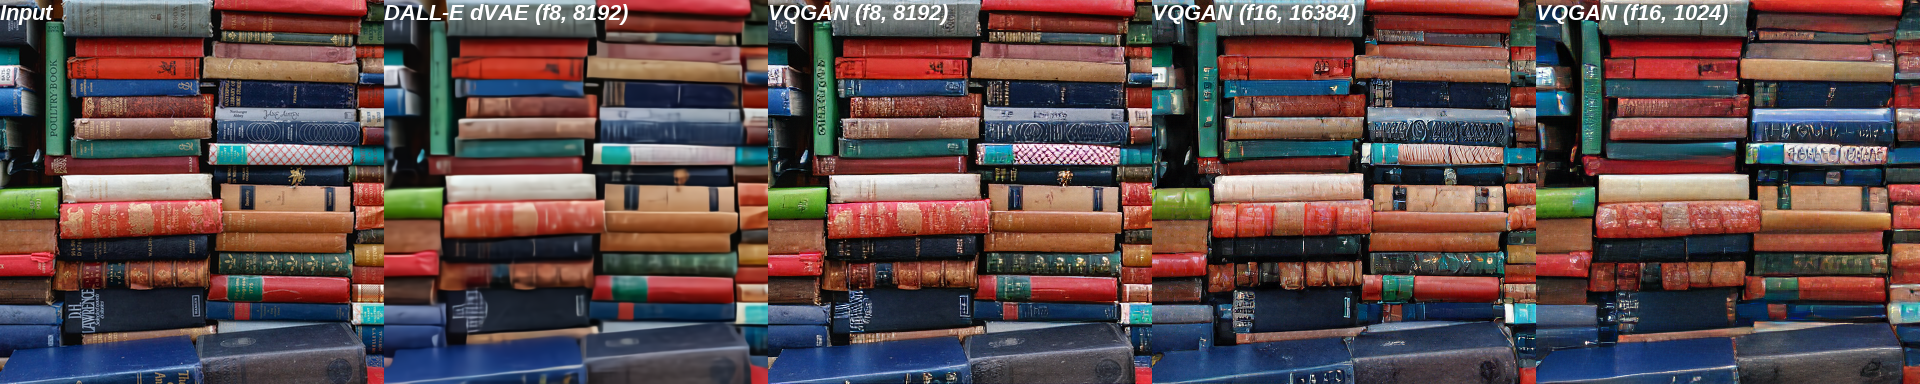

In [23]:
reconstruction_pipeline(url='https://images.unsplash.com/photo-1550399105-c4db5fb85c18?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1171&q=80', size=384)